# E-Commerce Data Science Portfolio

# Price Optimization

### Step 1: Import and Load

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor


order_items = pd.read_csv("../data/olist_order_items_dataset.csv")
products = pd.read_csv("../data/olist_products_dataset.csv")
orders = pd.read_csv("../data/olist_orders_dataset.csv")

# len in rows
print(f"Order items: {len(order_items)} rows")
print(f"Products: {len(products)} rows")
print(f"Orders: {len(orders)} rows")

Order items: 112650 rows
Products: 32951 rows
Orders: 99441 rows


### Step 2: Merge the 3 datasets

In [75]:
# Merge order items with product categories to get prices with categories
order_items_with_cats = pd.merge(order_items, products[['product_id', 
                                                        'product_category_name']], 
                                                         on='product_id', how='left')

# Show all the rows with price + category:

print(f"Data prepared: {len(order_items_with_cats)} rows with price and category info")

Data prepared: 112650 rows with price and category info


### Step 3: Show the different price ranges

In [76]:
print("Different ranges of prices -> (Min, Mean, Average, Max )\n")

price_stats = order_items_with_cats['price'].describe()
print(f"Price Statistics:")
print(f"Minimum price: R${price_stats['min']:.2f}")
print(f"Average price: R${price_stats['mean']:.2f}")
print(f"Median price: R${price_stats['50%']:.2f}")
print(f"Maximum price: R${price_stats['max']:.2f}")

Different ranges of prices -> (Min, Mean, Average, Max )

Price Statistics:
Minimum price: R$0.85
Average price: R$120.65
Median price: R$74.99
Maximum price: R$6735.00


### Step 4: Creating price brackets

In [77]:

print("\nCreate the price brackets:")

# Define price brackets to analyze customer purchasing behavior
price_brackets = [0, 25, 50, 100, 200, 500, 1000, float('inf')]
bracket_labels = ['0-25', '25-50', '50-100', '100-200', '200-500', '500-1000', '1000+']

# Categorize each product into price brackets
order_items_with_cats['price_bracket'] = pd.cut(order_items_with_cats['price'], bins=price_brackets, labels=bracket_labels)

print("Price brackets created successfully")


Create the price brackets:
Price brackets created successfully


### Step 5: Analyze the sales performance by price bracket

In [78]:
# Group data by price brackets and calculate the key metrics
bracket_sales = order_items_with_cats.groupby('price_bracket', observed=False).agg({
    'order_id': 'count',
    'price': 'mean',
    'freight_value': 'mean'
}).rename(columns={'order_id': 'units_sold', 'price': 'avg_price'})

# Calculate additional metrics
bracket_sales['revenue'] = bracket_sales['units_sold'] * bracket_sales['avg_price']
bracket_sales['percentage_of_sales'] = (bracket_sales['units_sold'] / len(order_items_with_cats)) * 100

print("\nSales Analysis by Price Bracket:")
for bracket in bracket_labels:
    if bracket in bracket_sales.index:
        data = bracket_sales.loc[bracket]
        print(f"  {bracket}: {data['units_sold']} units ({data['percentage_of_sales']:.1f}% of sales) - Avg: R${data['avg_price']:.2f}")

print("\nKey Findings from Price Brackets:")
print("--> The 50-100 R$ range is most popular with 29.3% of all sales")
print("--> 85% of sales happen in the affordable range (0-200 R$)")
print("--> Premium products (500+ R$) make up only 2.8% of sales volume")
print("--> Average price increases steadily across brackets as expected")


Sales Analysis by Price Bracket:
  0-25: 13795.0 units (12.2% of sales) - Avg: R$18.00
  25-50: 25522.0 units (22.7% of sales) - Avg: R$38.71
  50-100: 33020.0 units (29.3% of sales) - Avg: R$75.14
  100-200: 26939.0 units (23.9% of sales) - Avg: R$143.63
  200-500: 10158.0 units (9.0% of sales) - Avg: R$297.60
  500-1000: 2372.0 units (2.1% of sales) - Avg: R$691.87
  1000+: 844.0 units (0.7% of sales) - Avg: R$1589.00

Key Findings from Price Brackets:
--> The 50-100 R$ range is most popular with 29.3% of all sales
--> 85% of sales happen in the affordable range (0-200 R$)
--> Premium products (500+ R$) make up only 2.8% of sales volume
--> Average price increases steadily across brackets as expected


### Step 6: Four charts for price analysis

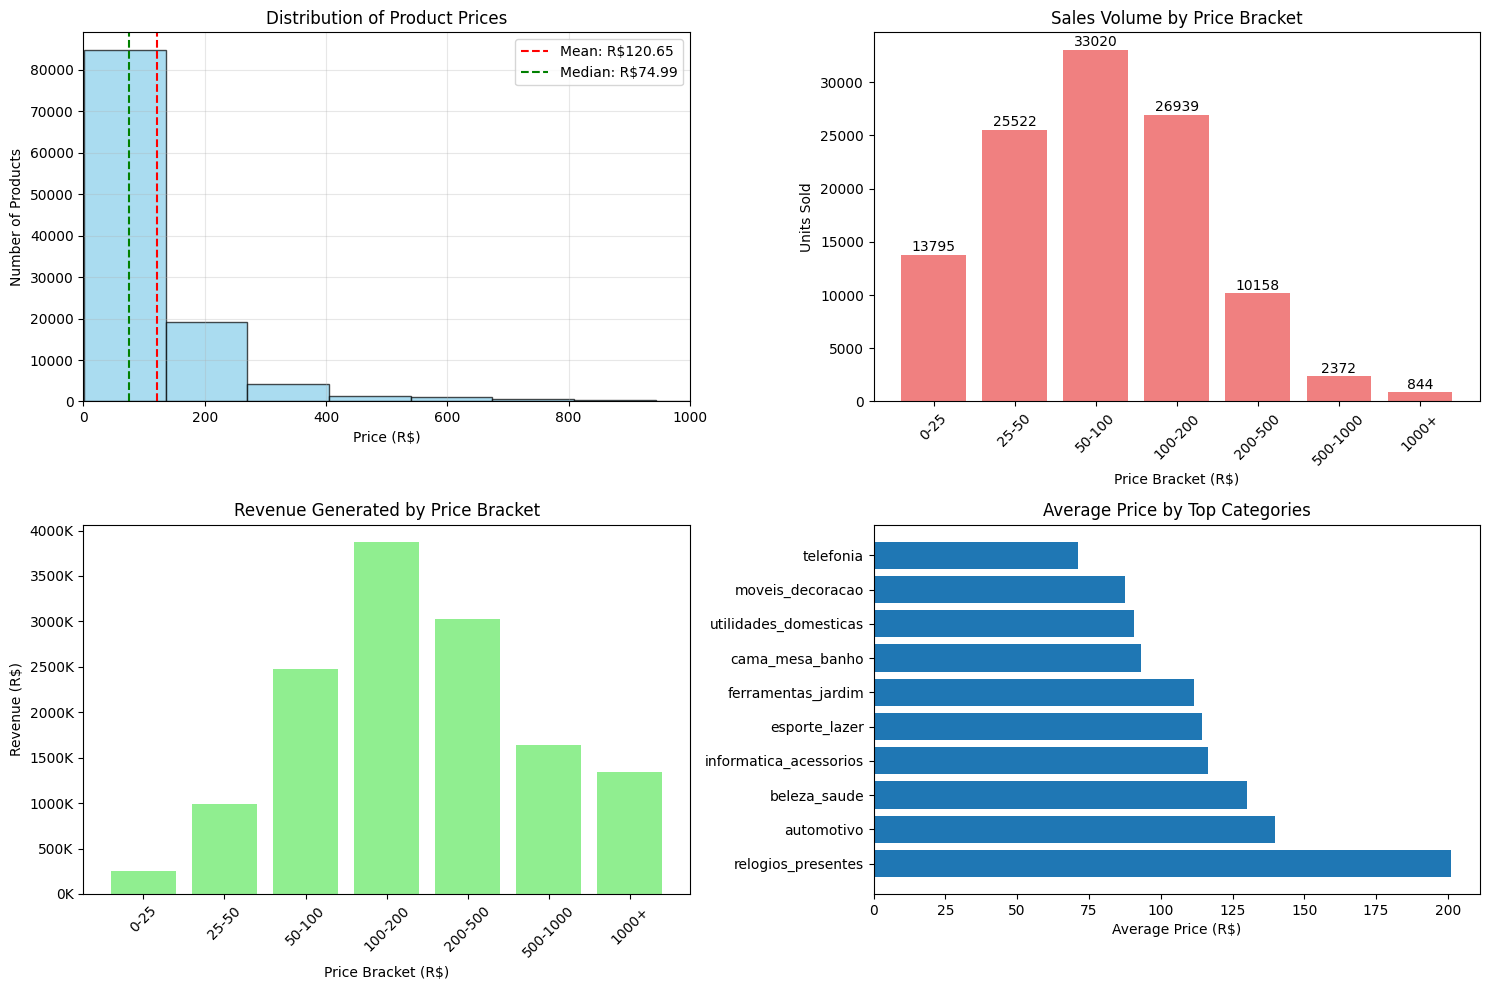

In [79]:
plt.figure(figsize=(15, 10))

# Plot 1: Price distribution histogram
plt.subplot(2, 2, 1)
plt.hist(order_items_with_cats['price'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('Price (R$)')
plt.ylabel('Number of Products')
plt.title('Distribution of Product Prices')
plt.axvline(order_items_with_cats['price'].mean(), color='red', linestyle='--', label=f'Mean: R${order_items_with_cats["price"].mean():.2f}')
plt.axvline(order_items_with_cats['price'].median(), color='green', linestyle='--', label=f'Median: R${order_items_with_cats["price"].median():.2f}')
plt.legend() # for the mean and median lines.
plt.grid(alpha=0.3) # transparency
plt.xlim(0, 1000) # make x limit -> 1000 as it's essentially empty from 1000---->

# Plot 2: Sales volume by price bracket
plt.subplot(2, 2, 2)
plt.bar(bracket_sales.index, bracket_sales['units_sold'], color='lightcoral')
plt.xlabel('Price Bracket (R$)')
plt.ylabel('Units Sold')
plt.title('Sales Volume by Price Bracket')
plt.xticks(rotation=45) # turn for space.

# Add value labels on bars
for i, v in enumerate(bracket_sales['units_sold']):
    plt.text(i, v + 50, str(v), ha='center', va='bottom')

# Plot 3: Revenue by price bracket
plt.subplot(2, 2, 3)
plt.bar(bracket_sales.index, bracket_sales['revenue'], color='lightgreen')
plt.xlabel('Price Bracket (R$)')
plt.ylabel('Revenue (R$)')
plt.title('Revenue Generated by Price Bracket')
plt.xticks(rotation=45)

# Format y-axis to show in thousands
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))

# Plot 4: Average price by top categories
plt.subplot(2, 2, 4)
top_categories = order_items_with_cats['product_category_name'].value_counts().head(10).index
category_prices = order_items_with_cats[order_items_with_cats['product_category_name'].isin(top_categories)]
avg_prices_by_cat = category_prices.groupby('product_category_name')['price'].mean().sort_values(ascending=True)

plt.barh(range(len(avg_prices_by_cat)), avg_prices_by_cat.values)
plt.yticks(range(len(avg_prices_by_cat)), avg_prices_by_cat.index)
plt.xlabel('Average Price (R$)')
plt.title('Average Price by Top Categories')
plt.gca().invert_yaxis() # invert top average price by top cat to be at bottom.

plt.tight_layout()
plt.show()

### Using Ml to see Price vs Product Variety on Sales

Using ML to see price vs Product Variety
Training on 58 categories

Feature Importance:
  avg_price: 0.014
  price_std: 0.010
  min_price: 0.011
  max_price: 0.016
  avg_freight: 0.014
  unique_products: 0.935

Key Finding: Product variety drives 93.5% of sales

ML Price Recommendations:
  cama_mesa_banho: R$93 → R$103 (Increase)
  beleza_saude: R$130 → R$143 (Increase)
  esporte_lazer: R$114 → R$126 (Increase)
  moveis_decoracao: R$88 → R$96 (Increase)
  informatica_acessorios: R$117 → R$128 (Increase)


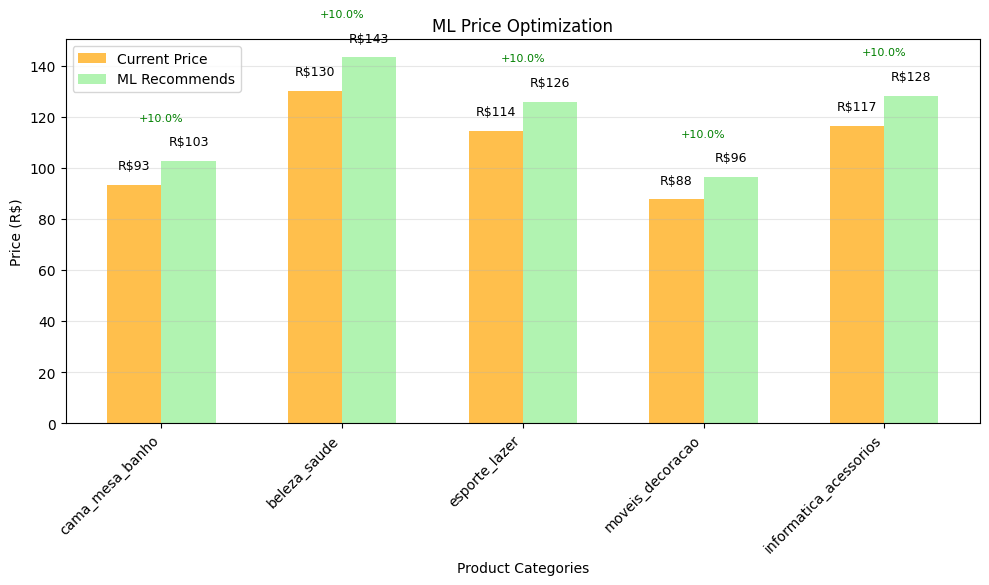

Even if price was increased by 10%, the major driving force when it comes to sales is product variety at 93.5%.


In [91]:
# ML Price Optimization Analysis
print("Using ML to see price vs Product Variety")


# Prepare data: Group sales by product category and calculate statistics
# This creates a dataset where each row is a product category with price and sales info
category_data = order_items_with_cats.groupby('product_category_name').agg({
    'price': ['mean', 'std', 'min', 'max'],  # Price statistics for each category
    'order_id': 'count',                     # Count of units sold
    'freight_value': 'mean',                 # Average shipping cost
    'product_id': 'nunique'                  # Number of unique products in category
}).round(2)

# Rename the columns for easier use and filter out categories with low sales
category_data.columns = ['avg_price', 'price_std', 'min_price', 'max_price', 'units_sold', 'avg_freight', 'unique_products']
category_data = category_data[category_data['units_sold'] > 50]  # Only keep categories with decent sales data

# there are 58 categories
print(f"Training on {len(category_data)} categories")

# Train ML model: Use category features to predict units sold
# Features include price stats, shipping costs, and product variety
features = category_data[['avg_price', 'price_std', 'min_price', 'max_price', 'avg_freight', 'unique_products']]
target = category_data['units_sold']  # Try to predict this

# Create and train Random Forest model - learns patterns from the data
model = RandomForestRegressor(n_estimators=100, random_state=42) 
model.fit(features, target)

# Feature importance: See which factors most affect sales
# The model tells us how much each feature contributes to predictions
feature_importance = model.feature_importances_
feature_names = features.columns

print("\nFeature Importance:")
for name, imp in zip(feature_names, feature_importance):
    print(f"  {name}: {imp:.3f}")

# Important finding ->> unique_products is the most important factor @ 93.5%
print(f"\nKey Finding: Product variety drives {feature_importance[5]:.1%} of sales")

# Price optimization: Test different prices to find what maximizes revenue
print("\nML Price Recommendations:")
top_categories = category_data.nlargest(5, 'units_sold')  # top 5 selling categories
recommendations = []

for category in top_categories.index:
    cat_features = features.loc[category].copy()  # Get features for this category
    current_price = cat_features['avg_price']     # Current average price
    
    # Test 3 price scenarios: 10% lower, current, 10% higher to see if price should change.
    test_prices = [current_price * 0.9, current_price, current_price * 1.1]
    best_revenue = 0
    best_price = current_price
    
    # For each test price, predict sales and calculate revenue
    for test_price in test_prices:
        test_features = cat_features.copy()
        test_features['avg_price'] = test_price  # Change only the price
        test_df = pd.DataFrame([test_features.values], columns=feature_names)
        
        predicted_sales = model.predict(test_df)[0]  # ML predicts sales at this price
        revenue = test_price * predicted_sales       # Calculate total revenue
        
        # Keep track of the price that gives highest revenue
        if revenue > best_revenue:
            best_revenue = revenue
            best_price = test_price
    
    # Calculate how much the recommended price differs from current
    revenue_change = ((best_price - current_price) / current_price) * 100
    recommendations.append({
        'category': category,
        'current': current_price,
        'best': best_price,
        'change': revenue_change
    })
    
    # Print recommendation for this category
    action = "Increase" if best_price > current_price else "Decrease" if best_price < current_price else "Keep"
    print(f"  {category}: R${current_price:.0f} → R${best_price:.0f} ({action})")

# Create chart comparing current vs recommended prices
plt.figure(figsize=(10, 6))

# Extract data for the chart
categories = [rec['category'] for rec in recommendations]
current_prices = [rec['current'] for rec in recommendations]
best_prices = [rec['best'] for rec in recommendations]
changes = [rec['change'] for rec in recommendations]

x_pos = np.arange(len(categories))
width = 0.30 # width of the bars.

# Create side-by-side bars: current prices vs ML recommended prices
plt.bar(x_pos - width/2, current_prices, width, label='Current Price', color='orange', alpha=0.7)
plt.bar(x_pos + width/2, best_prices, width, label='ML Recommends', color='lightgreen', alpha=0.7)

plt.xlabel('Product Categories')
plt.ylabel('Price (R$)')
plt.title('ML Price Optimization')
plt.xticks(x_pos, categories, rotation=45, ha='right')  # Rotate category names for readability
plt.legend() # add legend to say: current price & ML Recommends
plt.grid(alpha=0.3, axis='y')  # Add subtle grid lines

# Add value labels above bars and percentage changes
for i, (current, best, change) in enumerate(zip(current_prices, best_prices, changes)):
    plt.text(i - width/2, current + 5, f'R${current:.0f}', ha='center', va='bottom', fontsize=9)
    plt.text(i + width/2, best + 5, f'R${best:.0f}', ha='center', va='bottom', fontsize=9)
    plt.text(i, max(current, best) + 15, f'{change:+.1f}%', ha='center', va='bottom', fontsize=8,
             color='green' if change > 0 else 'red')  # Green for increase, red for decrease

plt.tight_layout()
plt.show()

print("Even if price was increased by 10%, the major driving force when it comes to sales is product variety at 93.5%.")

### Conclusion

In [85]:
print("\nIn conclusion we have learned:\n")

print("Price Optimization Insights:")
# Find optimal price points
most_popular_bracket = bracket_sales['units_sold'].idxmax() # where highest value
most_profitable_bracket = bracket_sales['revenue'].idxmax()

print(f"--> Most popular price bracket: {most_popular_bracket} (highest units sold)")
print(f"--> Most profitable price bracket: {most_profitable_bracket} (highest revenue)")

# Price sensitivity analysis
low_price_volume = bracket_sales.loc['0-25', 'units_sold'] if '0-25' in bracket_sales.index else 0
mid_price_volume = bracket_sales.loc['50-100', 'units_sold'] if '50-100' in bracket_sales.index else 0

print("\nCustomer Price Sensitivity:")
print(f"--> {low_price_volume} units sold in low price range (0-25 R$)")
print(f"--> {mid_price_volume} units sold in mid price range (50-100 R$)")

print("\nOptimal Price Strategy Findings:")
print("--> Customers show strong preference for affordable products (0-100 R$ range)")
print("--> Mid-range products (50-200 R$) balance volume and profit margin")
print("--> High-end products (500+ R$) have lower volume but contribute to revenue")

print("\nSummary:")
print(f"- Analyzed {len(order_items_with_cats)} product purchases")
print(f"- Identified {len(bracket_sales)} price brackets")
print(f"- Found optimal price range: {most_profitable_bracket}")

print("\nThe recommendations to take to improve the sales: ")
print("--> Focus on expanding mid-range product offerings (50-200 R$)")
print("--> Maintain competitive pricing in popular 0-50 R$ range")
print("--> Bundle low-cost items to increase average order value")
print("--> Use premium pricing strategically for unique/high-value items")

print("--> According to ML: Even if price was increased by 10%, expand Product Variety as it's driving sales (93.5% sales driver). \n    More variety -> more sales.")


In conclusion we have learned:

Price Optimization Insights:
--> Most popular price bracket: 50-100 (highest units sold)
--> Most profitable price bracket: 100-200 (highest revenue)

Customer Price Sensitivity:
--> 13795 units sold in low price range (0-25 R$)
--> 33020 units sold in mid price range (50-100 R$)

Optimal Price Strategy Findings:
--> Customers show strong preference for affordable products (0-100 R$ range)
--> Mid-range products (50-200 R$) balance volume and profit margin
--> High-end products (500+ R$) have lower volume but contribute to revenue

Summary:
- Analyzed 112650 product purchases
- Identified 7 price brackets
- Found optimal price range: 100-200

The recommendations to take to improve the sales: 
--> Focus on expanding mid-range product offerings (50-200 R$)
--> Maintain competitive pricing in popular 0-50 R$ range
--> Bundle low-cost items to increase average order value
--> Use premium pricing strategically for unique/high-value items
--> According to ML: